In [1]:
!nvidia-smi

Sun Oct 24 23:46:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.13       Driver Version: 496.13       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   55C    P5    22W /  N/A |    148MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## What is BERT?

BERT (introduced in [this paper](https://arxiv.org/abs/1810.04805)) stands for Bidirectional Encoder Representations from Transformers. If you don't know what most of that means - you've come to the right place! Let's unpack the main ideas:

- Bidirectional - to understand the text  you're looking you'll have to look back (at the previous words) and forward (at the next words)
- Transformers - The [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. `his` in a sentence refers to Jim).
- (Pre-trained) contextualized word embeddings - [The ELMO paper](https://arxiv.org/abs/1802.05365v2) introduced a way to encode words based on their meaning/context. Nails has multiple meanings - fingernails and metal nails.

BERT was trained by masking 15% of the tokens with the goal to guess them. An additional objective was to predict the next sentence. Let's look at examples of these tasks:

### Masked Language Modeling (Masked LM)

The objective of this task is to guess the masked tokens. Let's look at an example, and try to not make it harder than it has to be:

That's `[mask]` she `[mask]` -> That's what she said

### Next Sentence Prediction (NSP)

Given a pair of two sentences, the task is to say whether or not the second follows the first (binary classification). Let's continue with the example:

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Hahaha, nice! [SEP]

*Label* = *IsNext*

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Dwight, you ignorant `[mask]`! [SEP]

*Label* = *NotNext*

The training corpus was comprised of two entries: [Toronto Book Corpus](https://arxiv.org/abs/1506.06724) (800M words) and English Wikipedia (2,500M words). While the original Transformer has an encoder (for reading the input) and a decoder (that makes the prediction), BERT uses only the decoder.

BERT is simply a pre-trained stack of Transformer Encoders. How many Encoders? We have two versions - with 12 (BERT base) and 24 (BERT Large).

### Is This Thing Useful in Practice?

The BERT paper was released along with [the source code](https://github.com/google-research/bert) and pre-trained models.

The best part is that you can do Transfer Learning (thanks to the ideas from OpenAI Transformer) with BERT for many NLP tasks - Classification, Question Answering, Entity Recognition, etc. You can train with small amounts of data and achieve great performance!

## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertConfig
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from collections import defaultdict
from textwrap import wrap
from tqdm import tqdm
# from bertviz import head_view

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration

In [9]:
df = pd.read_csv("real_dataset/stormfront_train.tsv", delimiter='\t')
df.head()

,Unnamed: 0,text,is_hate
0,2351,"Also, it 's so sad to see so much pre made cra...",0
1,2557,2056,0
2,3523,I want to know where did Celtic Nation found t...,0
3,8740,"Ive talked to lots of punks about it , and i g...",0
4,10029,I am sorry but it is the truth .,0


In [ ]:
df.shape

(17932, 3)

We have about 17k examples. Let's check for missing values:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17932 entries, 0 to 17931
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  17932 non-null  int64 
 1   text        17932 non-null  object
 2   is_hate     17932 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 420.4+ KB


Great, no missing values! Do we have class imbalance?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'hate or not')

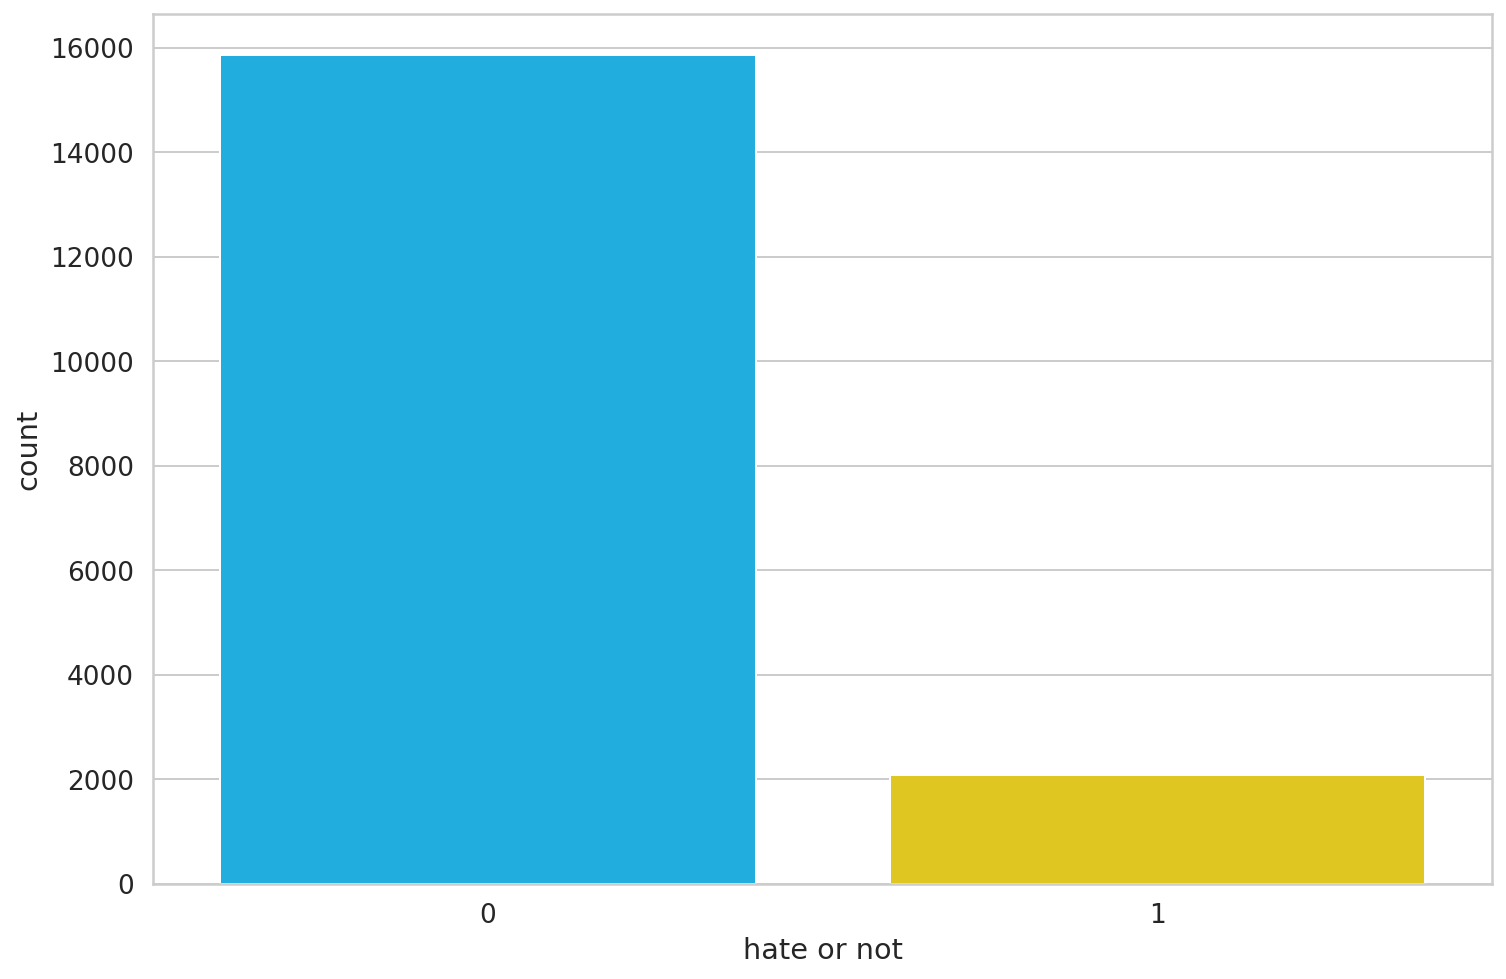

In [ ]:
sns.countplot(df['is_hate'])
plt.xlabel('hate or not')

That's hugely imbalanced, but at least this is how the paper did the preprocessing

In [3]:
def to_int(label):
  return int(label)

# df['label'] = df['is_hate'].apply(to_int)

In [4]:
class_names = ['non-hate', 'hate']

In [ ]:
df.head()

,Unnamed: 0,text,is_hate
0,592,"Watch the water slowly rise with me, lads! Edg...",0
1,6352,"It's a big ol' mess, eh? They're trying, and t...",0
2,2684,"No, he actually broke the law - hence why he's...",0
3,17427,ASSET FORFEITURE is LEGALIZED THEFT!,0
4,15295,this makes my blood boil my poor dad gave his ...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'non-hate'), Text(0, 0, 'hate')]

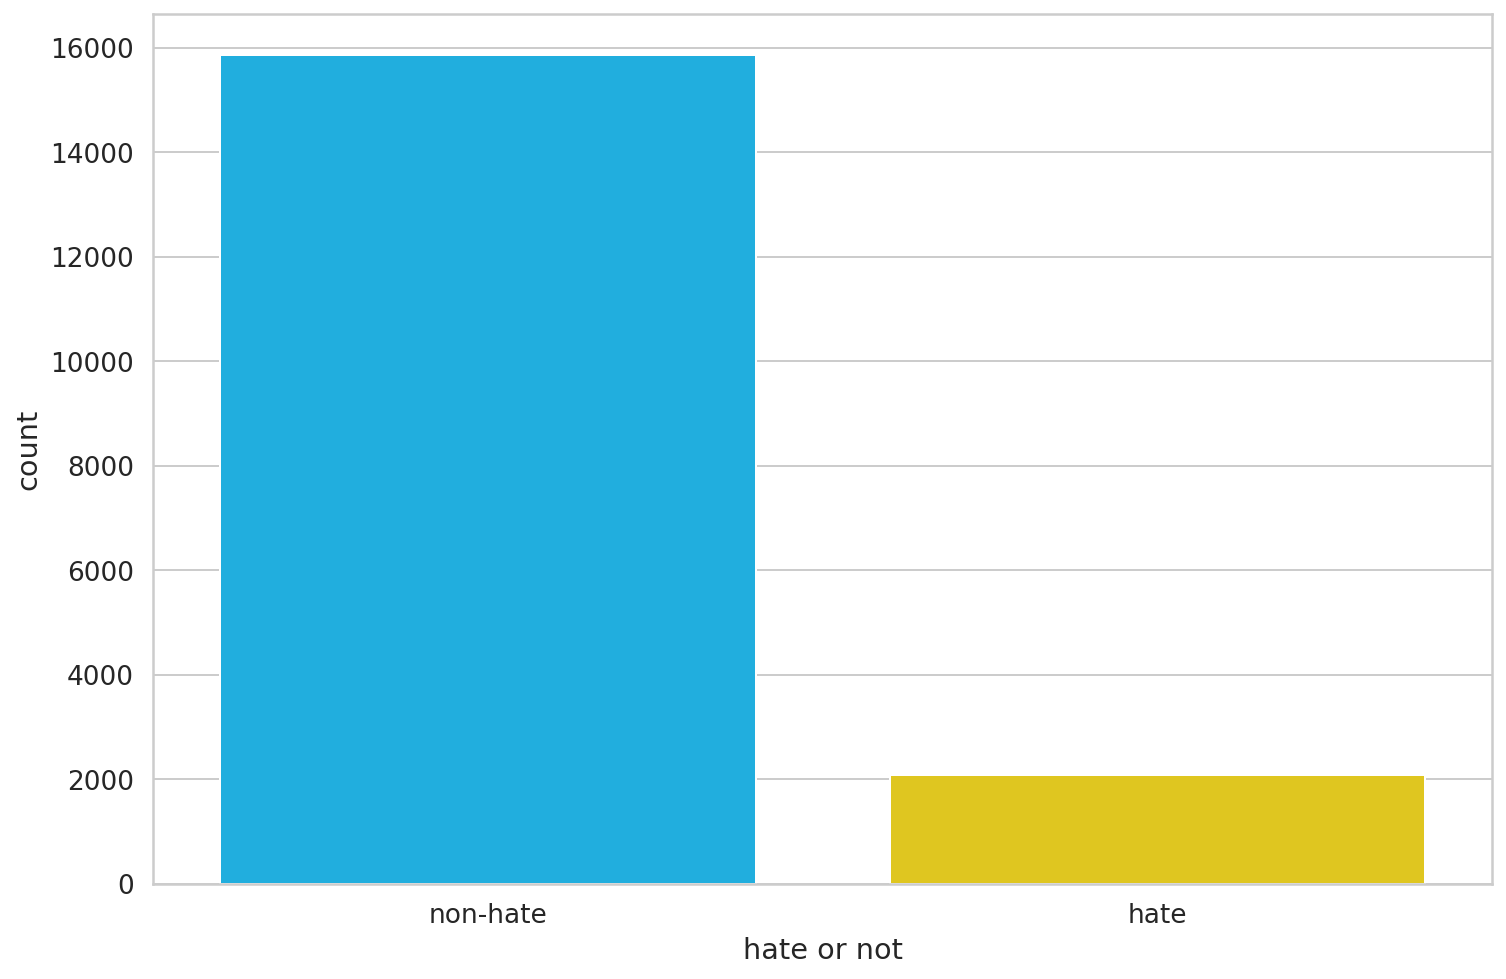

In [ ]:
ax = sns.countplot(df['is_hate'])
plt.xlabel('hate or not')
ax.set_xticklabels(class_names)

## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


In [4]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

> You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [5]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

We'll use this text to understand the tokenization process:

In [6]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [8]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


### Special Tokens

`[SEP]` - marker for ending of a sentence


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [8]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  truncation=True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [15]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

The attention mask has the same length:

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [10]:
token_lens = []

for txt in df['text']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

and plot the distribution:

In [11]:
np.mean(token_lens)

24.268395234758234

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

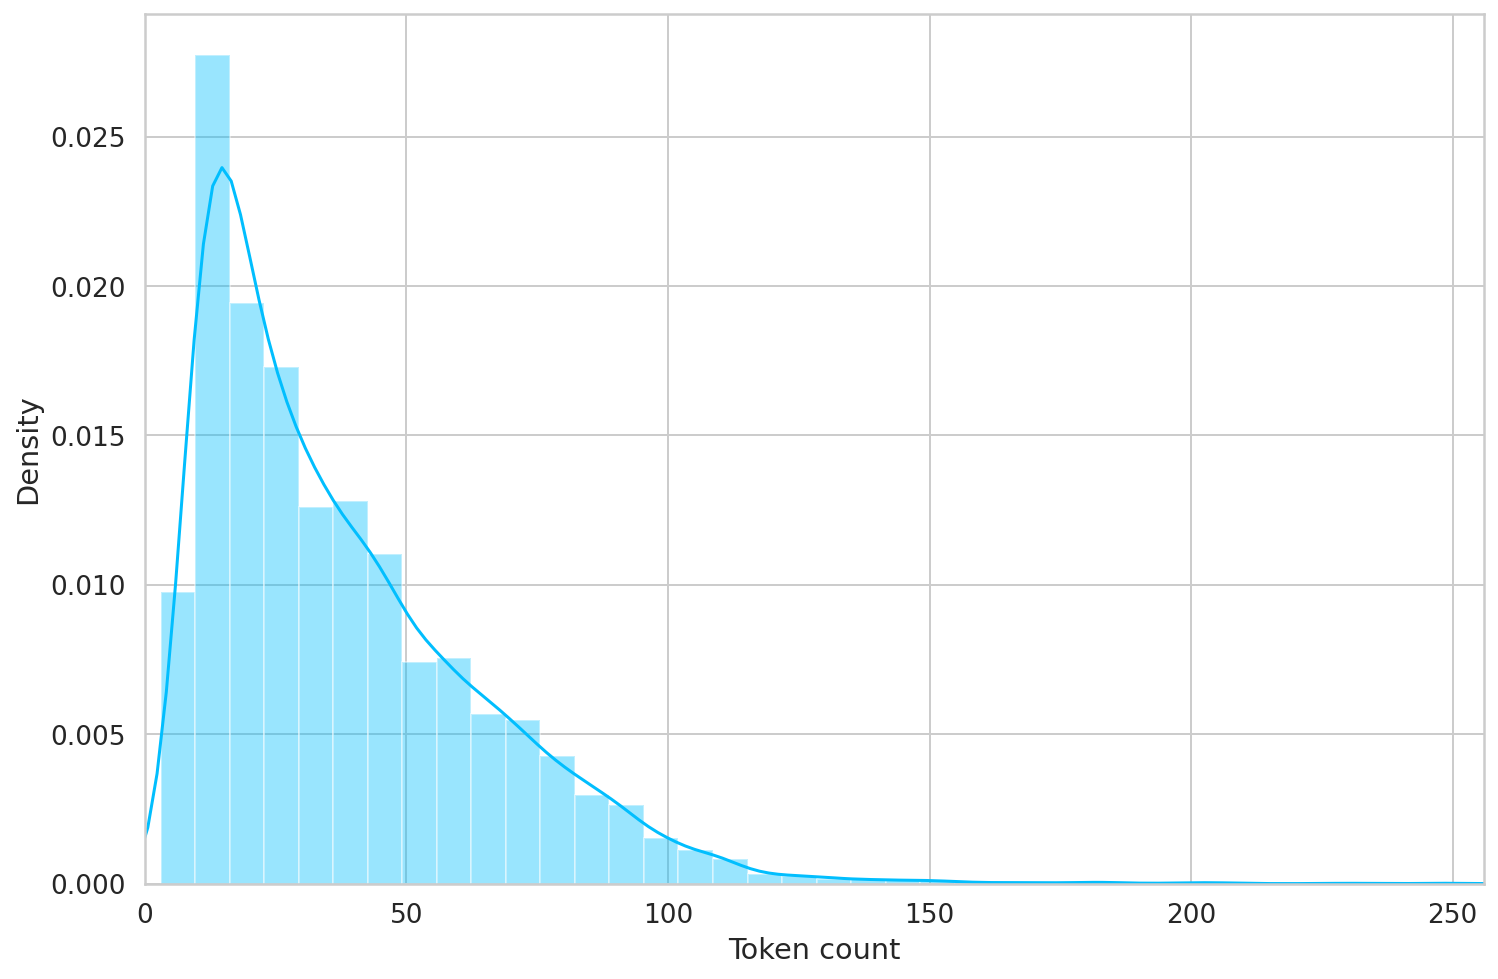

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token count')

Most of the reviews seem to contain less than 150 tokens, but we'll be on the safe side and choose a maximum length of 256.

In [15]:
MAX_LEN = 256

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [9]:
class GHCDataset(Dataset):

  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [10]:
# df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
# df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

# df_train = pd.read_csv('real_dataset/ghc_train.tsv', delimiter='\t')
# df_val = pd.read_csv('real_dataset/ghc_val.tsv', delimiter='\t')
# df_test = pd.read_csv('real_dataset/ghc_test.tsv', delimiter='\t')

# df_train = pd.read_csv('real_dataset/stormfront_train.tsv', delimiter='\t')
# df_val = pd.read_csv('real_dataset/stormfront_val.tsv', delimiter='\t')
# df_test = pd.read_csv('real_dataset/stormfront_test.tsv', delimiter='\t')

df_train = pd.read_csv('real_dataset/ghc_wr_train.tsv', delimiter='\t')
df_val = pd.read_csv('real_dataset/ghc_wr_val.tsv', delimiter='\t')
df_test = pd.read_csv('real_dataset/ghc_wr_test.tsv', delimiter='\t')


In [11]:
df_train['label'] = df_train['is_hate'].apply(to_int)
df_val['label'] = df_val['is_hate'].apply(to_int)
df_test['label'] = df_test['is_hate'].apply(to_int)

In [12]:
df_train.shape, df_val.shape, df_test.shape

((17932, 4), (2241, 4), (2242, 4))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [16]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GHCDataset(
    text=df['text'].to_numpy(),
    targets=df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    # windows does not support num_workers > 0. Set it to 0 (default) if you are using windows
    # num_workers=2
  )

In [17]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [18]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])

In [50]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])


In [51]:
print(data['targets'])

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


## Hate Speech Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [19]:
config = BertConfig.from_pretrained(PRE_TRAINED_MODEL_NAME, output_hidden_states=True, output_attentions=True)  

In [20]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, config=config)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


And try to use it on the encoding of our sample text:

In [30]:
# last_hidden_state, pooled_output = bert_model(
#   input_ids=encoding['input_ids'], 
#   attention_mask=encoding['attention_mask']
# )

output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [31]:
last_hidden_states = output.last_hidden_state
pooler_output = output.pooler_output
hidden_states = output.hidden_states
attentions = output.attentions

In [ ]:
[a.shape for a in attentions]

[torch.Size([1, 12, 32, 32]),
 torch.Size([1, 12, 32, 32]),
 torch.Size([1, 12, 32, 32]),
 torch.Size([1, 12, 32, 32]),
 torch.Size([1, 12, 32, 32]),
 torch.Size([1, 12, 32, 32]),
 torch.Size([1, 12, 32, 32]),
 torch.Size([1, 12, 32, 32]),
 torch.Size([1, 12, 32, 32]),
 torch.Size([1, 12, 32, 32]),
 torch.Size([1, 12, 32, 32]),
 torch.Size([1, 12, 32, 32])]

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [ ]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

In [ ]:
pooler_output.shape

torch.Size([1, 768])

In [ ]:
last_hidden_states.shape

torch.Size([1, 32, 768])

We can use all of this knowledge to create a classifier that uses the BERT model:

In [21]:
class GHCClassifier(nn.Module):

  def __init__(self, n_classes):
    super(GHCClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, output_attentions=True)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    pooler_output = self.drop(output.pooler_output)
    return self.out(pooler_output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [22]:
model = GHCClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We'll move the example batch of our training data to the GPU:

In [21]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

NameError: ignored

To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [35]:
test_output = F.softmax(model(input_ids, attention_mask), dim=1)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [23]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss(weight = torch.tensor([1.0, 8.0])).to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [24]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  predictions = []
  real_values = []
  correct_predictions = 0
  
  for d in tqdm(data_loader):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    predictions.extend(preds)
    real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()

  return correct_predictions.double() / n_examples, np.mean(losses), classification_report(real_values, predictions, target_names=class_names), f1_score(real_values, predictions, labels=1)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [25]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  predictions = []
  real_values = []
  correct_predictions = 0

  with torch.no_grad():
    for d in tqdm(data_loader):
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      predictions.extend(preds)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()

  return correct_predictions.double() / n_examples, np.mean(losses), classification_report(real_values, predictions, target_names=class_names), f1_score(real_values, predictions, labels=1)

Using those two, we can write our training loop. We'll also store the training history:

In [26]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop_count = 0
prev_f1 = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss, train_report, train_f1 = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  print(train_report)

  val_acc, val_loss, val_report, val_f1 = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print(val_report)
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

  # if prev_f1 > val_f1:
  #   early_stop_count += 1;
  #   print(f'early stop count is now {early_stop_count}.')
  # else:
  #   early_stop_count = 0;
  #   print(f'early stop count has been reset to {early_stop_count}.')
  
  # if early_stop_count >= 5:
  #   print('early stop!')

Epoch 1/3
----------


100%|██████████| 1121/1121 [05:56<00:00,  3.14it/s]


Train loss 0.7197740706984854 accuracy 0.5704885121570378
              precision    recall  f1-score   support

    non-hate       0.88      0.59      0.71     15859
        hate       0.11      0.40      0.18      2073

    accuracy                           0.57     17932
   macro avg       0.50      0.49      0.44     17932
weighted avg       0.79      0.57      0.65     17932



100%|██████████| 141/141 [00:13<00:00, 10.24it/s]
C:\Users\stwan\anaconda3\envs\CS_4650_Proj\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stwan\anaconda3\envs\CS_4650_Proj\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stwan\anaconda3\envs\CS_4650_Proj\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Val   loss 0.6786600710652398 accuracy 0.893797411869701
              precision    recall  f1-score   support

    non-hate       0.89      1.00      0.94      2003
        hate       0.00      0.00      0.00       238

    accuracy                           0.89      2241
   macro avg       0.45      0.50      0.47      2241
weighted avg       0.80      0.89      0.84      2241


Epoch 2/3
----------


100%|██████████| 1121/1121 [05:49<00:00,  3.20it/s]


Train loss 0.7123551985230646 accuracy 0.5813071603836717
              precision    recall  f1-score   support

    non-hate       0.89      0.60      0.72     15859
        hate       0.12      0.41      0.18      2073

    accuracy                           0.58     17932
   macro avg       0.50      0.51      0.45     17932
weighted avg       0.80      0.58      0.66     17932



 94%|█████████▍| 133/141 [00:13<00:00, 10.05it/s]


KeyboardInterrupt: 

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

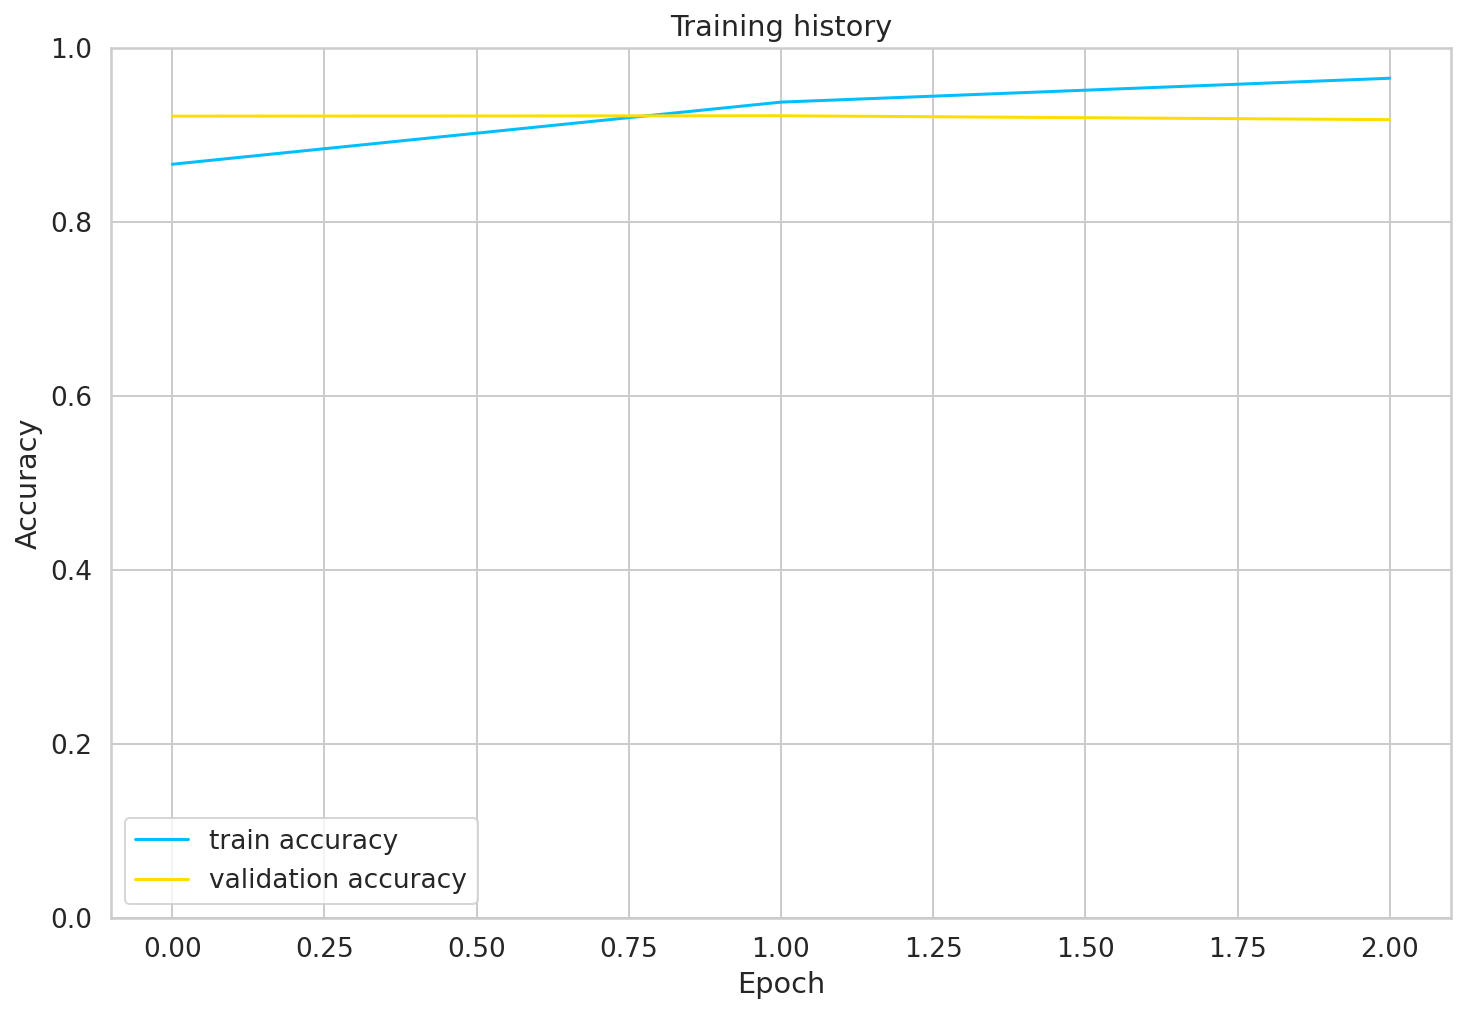

In [29]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

Uncomment the next cell to load the model:

In [ ]:
model = GHCClassifier(len(class_names))
model.load_state_dict(torch.load('ghc_best_model_state.bin'))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
# sample_txt = "Watch the water slowly rise with me, lads! Edge of your seat stuff. Watching for 'gators...  #Harvey   Water at 36.5' in Buffalo Bayou  https://youtu.be/cZGJZH6VW-k"
# inputs = tokenizer.encode_plus(
#   sample_txt,
#   max_length=256,
#   truncation=True,
#   add_special_tokens=True, # Add '[CLS]' and '[SEP]'
#   return_token_type_ids=False,
#   padding='max_length',
#   return_attention_mask=True,
#   return_tensors='pt',  # Return PyTorch tensors
# )

# # inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
# attention_mask = inputs['attention_mask'].to(device)
# input_ids = inputs['input_ids'].to(device)
# _, attention = model(input_ids, attention_mask=attention_mask)[-1]
# input_id_list = input_ids[0].tolist() # Batch index 0
# tokens = tokenizer.convert_ids_to_tokens(input_id_list)

In [31]:
# head_view(attention, tokens)

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [ ]:
test_acc, _, _, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

100%|██████████| 141/141 [01:05<00:00,  2.15it/s]


0.9197145405887601

We'll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report

In [ ]:
f1_score(y_test, y_pred, labels=1)

0.6311475409836066

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    non-hate       0.95      0.96      0.95      1990
        hate       0.65      0.61      0.63       252

    accuracy                           0.92      2242
   macro avg       0.80      0.78      0.79      2242
weighted avg       0.92      0.92      0.92      2242



Continue with the confusion matrix:

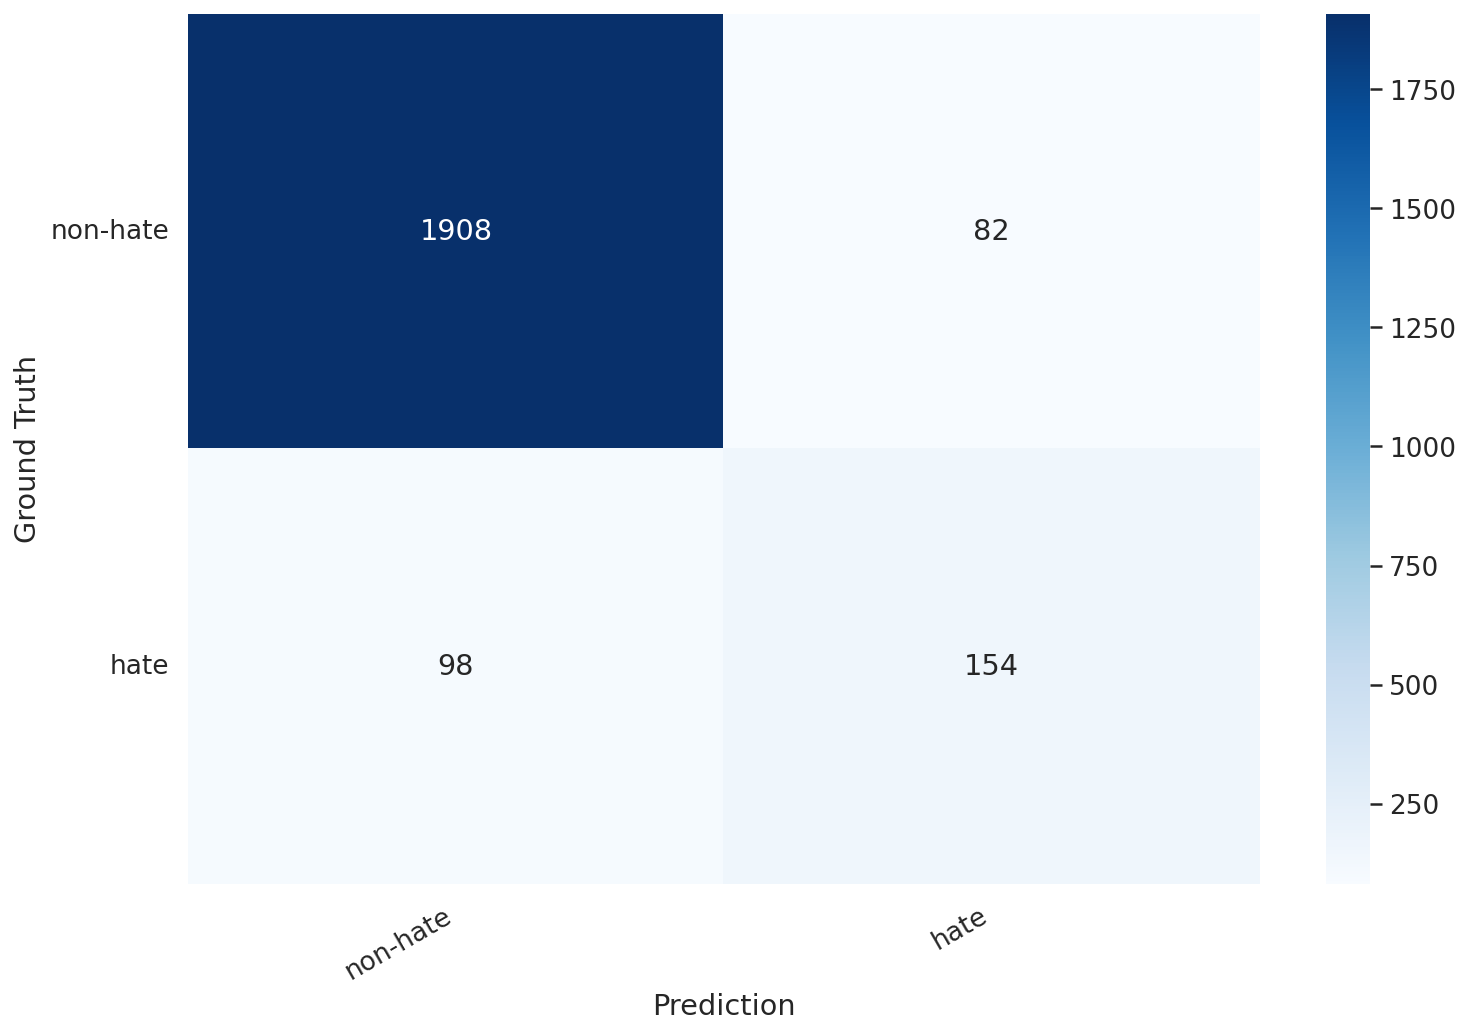

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Ground Truth')
  plt.xlabel('Prediction');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_label = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True label: {class_names[true_label]}')

Which preamble are you speaking of? For the DoI or the USC ?

True label: non-hate


Now we can look at the confidence of each label of our model:

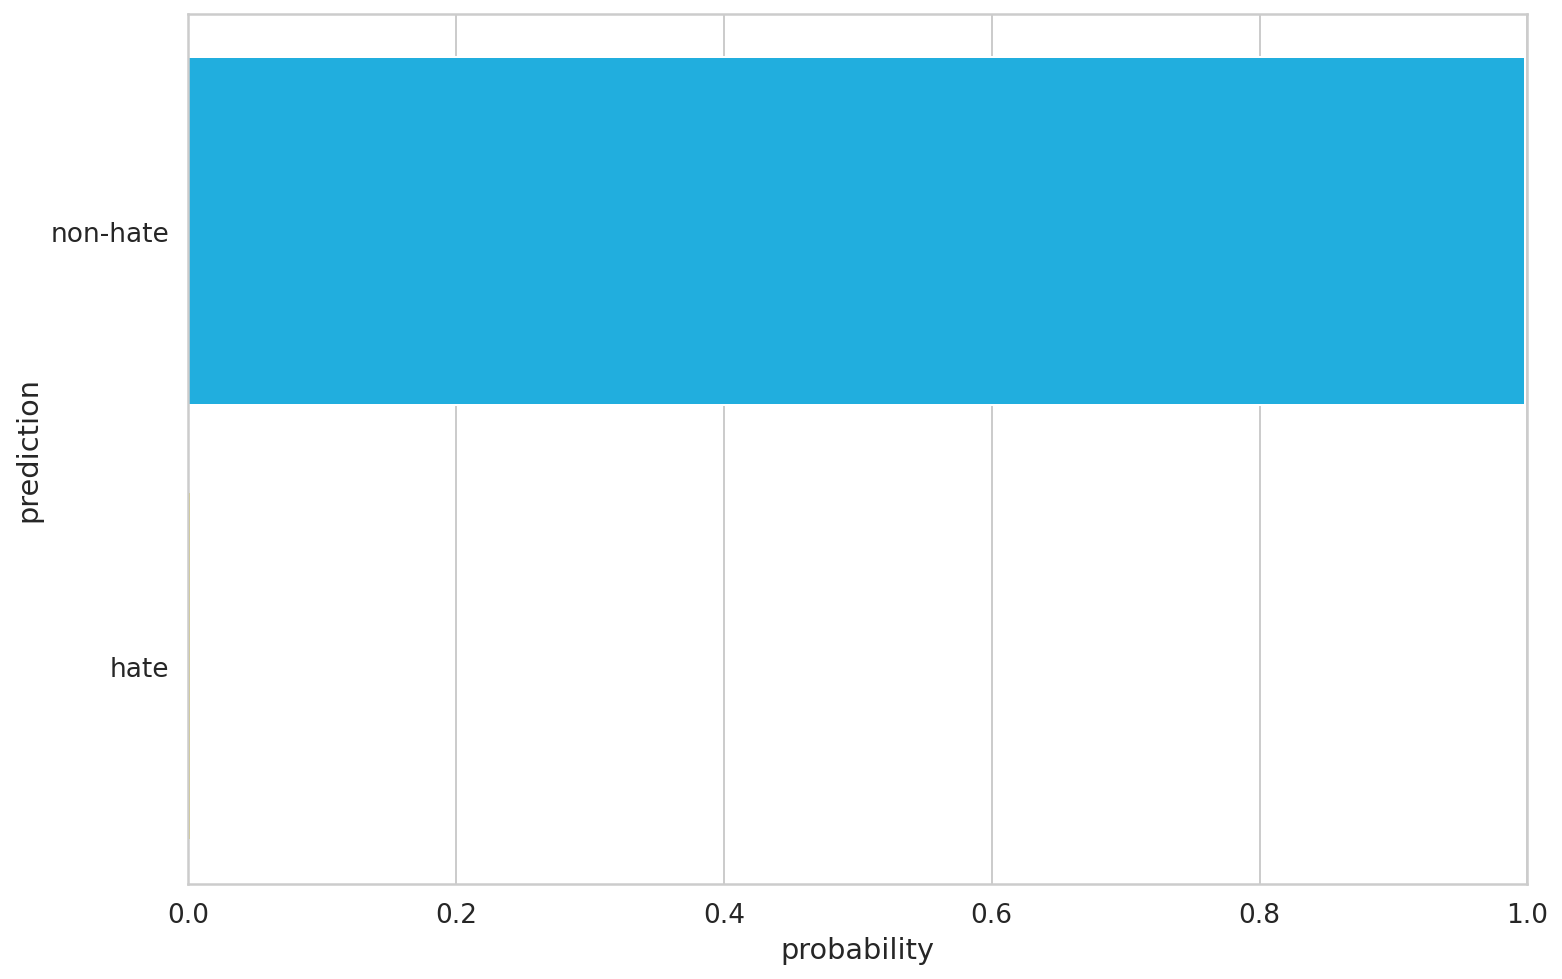

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('prediction')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to classify hate speech of some raw text:

In [ ]:
# review_text = "I love completing my todos! Best app ever!!!"
review_text = "I hate asian!"

We have to use the tokenizer to encode the text:

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  truncation=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
)

Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'prediction  : {class_names[prediction]}')

Review text: I hate asian!
prediction  : non-hate


## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)